In [1]:
# from train import Train
# from model import RNN_custom
# dataroot = "/Users/akshita/Documents/Acads/data/sentiment_analysis/"
# path_to_saved_embeddings = "/Users/akshita/Documents/Acads/data/word2vec"

# train = Train(dataroot, path_to_saved_embeddings=path_to_saved_embeddings)
# net = RNN_custom(300, 512, 2, True, 2)
# name = "RNN_custom"
# train.train(net, name, data_size=400, lr=1e-5, momentum=0.9, epochs=1)

Done loading data
Starting training


/Users/akshita/opt/anaconda3/envs/ece60146/lib/python3.8/site-packages/DLStudio/DLStudio.py:5231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272482218/work/torch/csrc/utils/tensor_new.cpp:201.)
  review_tensor = torch.FloatTensor( list_of_embeddings )
/Users/akshita/opt/anaconda3/envs/ece60146/lib/python3.8/site-packages/DLStudio/DLStudio.py:5231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272482218/work/torch/csrc/utils/tensor_new.cpp:201.)
  review_tensor = torch.FloatTensor( list_of_embeddings )


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/akshita/opt/anaconda3/envs/ece60146/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3442, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/j4/wb_q1s_s6cl43n5d2r4t8p3w0000gn/T/ipykernel_32132/1387191538.py", line 9, in <module>
    train.train(net, name, data_size=400, lr=1e-5, momentum=0.9, epochs=1)
  File "/Users/akshita/Documents/Acads/ECE60146/HW8/train.py", line 82, in train
    output = net(review_tensor)
  File "/Users/akshita/opt/anaconda3/envs/ece60146/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1102, in _call_impl
    return forward_call(*input, **kwargs)
  File "/Users/akshita/Documents/Acads/ECE60146/HW8/model.py", line 94, in forward
TypeError: 'module' object is not callable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/akshita/opt/anaconda3/envs/ece60146/lib/python3.8/site-p

In [4]:
from DLStudio import DLStudio

import torch
from torch import optim
from torch import nn as nn 
from torch.autograd import Variable

import numpy as np
import csv


In [5]:
dataroot = "/Users/akshita/Documents/Acads/data/sentiment_analysis/"
dataset_archive_train = "sentiment_dataset_train_400.tar.gz"
dataset_archive_test = "sentiment_dataset_test_400.tar.gz"
path_to_saved_embeddings = "/Users/akshita/Documents/Acads/data/word2vec"

In [6]:
class MyGRU(nn.Module):
    def __init__(self, 
                 input_size, 
                 hidden_size, 
                 bias=True):
        """
        Args:
            input_size: size of input vectors
            hidden_size: size of hidden state vectors
            bias: whether to use bias parameters or not
        """
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        self.x2h = nn.Linear(input_size, 3 * hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, 3 * hidden_size, bias=bias)

        self.reset_parameters()


    def reset_parameters(self):
        # Initialize all weights uniformly in the range [-1/sqrt(n), 1/sqrt(n)]
        # n = hidden_size
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):
        """
        Args:
            input: of shape (batch_size, input_size)
            hx: of shape (batch_size, hidden_size)

        Returns:    
            hy: of shape (batch_size, hidden_size)
        """
        
        if hx is None:
            hx = Variable(input.new_zeros(input.size(0), self.hidden_size))

        # Compute x_t and h_t
        x_t = self.x2h(input)
        h_t = self.h2h(hx)

        # we split the output of the linear layers into 3 parts
        # each of size hidden_size
        x_reset, x_upd, x_new = x_t.chunk(3, 1)
        h_reset, h_upd, h_new = h_t.chunk(3, 1)

        # compute the reset, update and new gates
        reset_gate = torch.sigmoid(x_reset + h_reset)
        update_gate = torch.sigmoid(x_upd + h_upd)
        new_gate = torch.tanh(x_new + (reset_gate * h_new))

        hy = update_gate * hx + (1 - update_gate) * new_gate

        return hy
    
class RNN_custom(nn.Module):
    def __init__(self, 
                 input_size, 
                 hidden_size,
                 num_layers, 
                 bias,
                output_size
                ):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.output_size = output_size

        # list of GRU cells
        self.rnn_list = nn.ModuleList()
        self.rnn_list.append(MyGRU(input_size, 
                                     hidden_size, 
                                     bias))
        for i in range(num_layers-1):
            self.rnn_list.append(MyGRU(hidden_size, 
                                         hidden_size, 
                                         bias))
        # feedforward layer
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, input, hx=None):
        """
        Args:
            input: of shape (batch_size, seq_len, input_size)
            hx: of shape (batch_size, hidden_size)

        Returns:
            output: of shape (batch_size, output_size)
        """
        batch_size, seq_len, _ = input.shape

        if hx is None:
            h0 = Variable(torch.zeros(self.num_layers,
                                      batch_size,
                                      self.hidden_size))
        else:
            h0 = hx
        
        # list of hidden states
        h_list = []
        outs = []
        for i in range(self.num_layers):
            h_list.append(h0[i, :, :])
        
        # for each time step
        for t in range(seq_len):
            for i in range(self.num_layers):
                if i == 0:
                    h_l = self.rnn_list[i](input[:, t, :], h_list[i])
                else:
                    h_l = self.rnn_list[i](h_list[i-1], h_list[i])
                h_list[i] = h_l
            outs.append(h_l)
        # feedforward layer
        output = self.linear(outs[-1].squeeze(0))
        return output

In [7]:
#taken from Avi's code

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dls = DLStudio(
                  dataroot = dataroot,
                  path_saved_model = "./saved_model",
                  momentum = 0.9,
                  learning_rate =  1e-5,
                  epochs = 1,
                  batch_size = 1,
                  classes = ('negative','positive'),
                  use_gpu = True if torch.cuda.is_available() else False,
              )

text_cl = DLStudio.TextClassificationWithEmbeddings( dl_studio = dls )

dataserver_train = DLStudio.TextClassificationWithEmbeddings.SentimentAnalysisDataset(
                                 train_or_test = 'train',
                                 dl_studio = dls,
                                 dataset_file = dataset_archive_train,
                                 path_to_saved_embeddings = path_to_saved_embeddings,
                   )
dataserver_test = DLStudio.TextClassificationWithEmbeddings.SentimentAnalysisDataset(
                                 train_or_test = 'test',
                                 dl_studio = dls,
                                 dataset_file = dataset_archive_test,
                                 path_to_saved_embeddings = path_to_saved_embeddings,
                  )
text_cl.dataserver_train = dataserver_train
text_cl.dataserver_test = dataserver_test

text_cl.load_SentimentAnalysisDataset(dataserver_train, dataserver_test)

In [30]:
class UNI_GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1) -> None:
        super(UNI_GRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax()
    
    def forward(self, x):
        h = torch.zeros(self.num_layers, x.size(1), self.hidden_size).requires_grad_()
        # Forward propagation by passing in the input and hidden state into the model
        out, h = self.gru(x, h.detach())
        # print(out.shape)
        out = self.fc(self.relu(out[:, -1]))
        out = self.logsoftmax(out)
        return out, h
    

class BI_GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1) -> None:
        super().__init__()
        self.input_size = input_size 
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, output_size)
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax()

    def forward(self, x):
        h = torch.zeros(2*self.num_layers, x.size(1), self.hidden_size).requires_grad_()
        # print(h.shape)
        out, h = self.gru(x,h)
        print(out.shape, out[:, -1].shape)
        out = self.fc(self.relu(out[:, -1]))
        out = self.logsoftmax(out)
        return out, h
    
net_uni = UNI_GRU(300, 512, 2, 1)
net_bi = BI_GRU(300, 512, 2, 1)

In [33]:
def train(net, dataloader, name='uni', epochs=1):
    net = net.to(device)
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(net.parameters(), lr=1e-5, betas=(0.9, 0.999))
    print("training")
    running_loss = 0.0
    for epoch in range(epochs):
        for i, data in tqdm(enumerate(dataloader)):
            review_tensor = data['review']
            sentiment = data['sentiment']
            review_tensor = review_tensor.to(device)
            sentiment = sentiment.to(device)

            optimizer.zero_grad()
            output, _ = net(review_tensor)
            loss = criterion(output, torch.argmax(sentiment, dim=1))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            

train(net_uni, text_cl.train_dataloader, name='uni', epochs=1)

training


/Users/akshita/opt/anaconda3/envs/ece60146/lib/python3.8/site-packages/DLStudio/DLStudio.py:5231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272482218/work/torch/csrc/utils/tensor_new.cpp:201.)
  review_tensor = torch.FloatTensor( list_of_embeddings )
/Users/akshita/opt/anaconda3/envs/ece60146/lib/python3.8/site-packages/DLStudio/DLStudio.py:5231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272482218/work/torch/csrc/utils/tensor_new.cpp:201.)
  review_tensor = torch.FloatTensor( list_of_embeddings )


tensor([[1, 0]])
0 tensor([[-0.7041, -0.6823]], grad_fn=<LogSoftmaxBackward0>) tensor(0)


/var/folders/j4/wb_q1s_s6cl43n5d2r4t8p3w0000gn/T/ipykernel_32132/2853578283.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.logsoftmax(out)


UnboundLocalError: local variable 'running_loss' referenced before assignment

In [ ]:
def train_with_my_gru(net, name, device):
    net = net.to(device)
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(net.parameters(), lr = dls.learning_rate, betas=(dls.momentum, 0.999))
    training_loss_tally = list()
    softmax = nn.Softmax(dim=0)
    loss_flag = 1e32
    for epoch in range(dls.epochs):
        running_loss = 0.0
        for i, data in enumerate(text_cl.train_dataloader):
            # get a sample from the train loader
            review_tensor = data['review']
            sentiment = data['sentiment']

            review_tensor = review_tensor.to(device)
            sentiment = sentiment.to(device)

            optimizer.zero_grad()
            output = net(review_tensor)
            output = softmax(output)
            loss = criterion(output, torch.argmax(sentiment))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            if i % 10 == 9:
                row = [epoch, i, running_loss / 10]
                with open(f'./solutions/{name}_training_log.csv', 'a') as csvFile:
                    writer = csv.writer(csvFile)
                    writer.writerow(row)
                if running_loss < loss_flag:
                    loss_flag = running_loss
                    torch.save(net.state_dict(), f'./solutions/{name}_best_model.pt')
                    
                running_loss = 0.0
    # return training_loss_tally

net = RNN_custom(300, 512, 2, True, 2)
train_with_my_gru(net, 'my_gru', device)

/Users/akshita/opt/anaconda3/envs/ece60146/lib/python3.8/site-packages/DLStudio/DLStudio.py:5231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272482218/work/torch/csrc/utils/tensor_new.cpp:201.)
  review_tensor = torch.FloatTensor( list_of_embeddings )
/Users/akshita/opt/anaconda3/envs/ece60146/lib/python3.8/site-packages/DLStudio/DLStudio.py:5231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272482218/work/torch/csrc/utils/tensor_new.cpp:201.)
  review_tensor = torch.FloatTensor( list_of_embeddings )


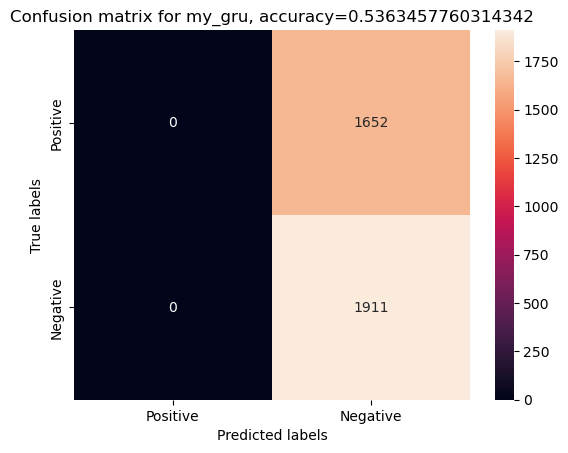

In [12]:
# from sklearn.metrics import confusion_matrix, accuracy_score
# import seaborn as sns
# import matplotlib.pyplot as plt
# import torch
# import pickle 
# def validation(net, text_cl, name):
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     net = net.to(device)
#     net.eval()    
#     true = []
#     pred = []
#     with torch.no_grad():
#         for i, data in enumerate(text_cl.test_dataloader):
#             # get a sample from the test loader
#             review_tensor, sentiment = data['review'], data['sentiment'] 
            
#             # send review and sentiment tensor to cuda
#             review_tensor = review_tensor.to(device)
#             sentiment = sentiment.to(device)

#             output = net(review_tensor)
#             pred.append(torch.argmax(output).item())
#             true.append(torch.argmax(sentiment).item())
#         pickle.dump(true, open(f"./solutions/{name}_true.pkl", "wb"))
#         pickle.dump(pred, open(f"./solutions/{name}_pred.pkl", "wb"))

#     return true, pred

# def validate_and_conf_matrix(net, val_dataset, categories, name="Net") -> None:
#     t, p = validation(net, val_dataset)
#     cm = confusion_matrix(t, p)
#     plt.figure()
#     sns.heatmap(cm, annot=cm, xticklabels=categories, yticklabels=categories, fmt="g")
#     plt.title(f"Confusion matrix for {name}, accuracy={accuracy_score(t, p)}")
#     plt.xlabel("Predicted labels")
#     plt.ylabel("True labels")
#     plt.savefig(f"./solutions/cm_{name}.png")


# net = RNN_custom(300, 512, 2, True, 2)
# net.load_state_dict(torch.load("./solutions/my_gru_best_model.pt", map_location=torch.device('cpu')))

# validate_and_conf_matrix(net, text_cl, categories=["Positive", "Negative"], name="my_gru")